## Importando librerías y configuraciones

In [37]:
# Manejo de archivos y operaciones numéricas
import os
import numpy as np
import pandas as pd

# Procesamiento de sonido y fonética
import parselmouth

# Machine Learning
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.svm import SVC

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
#from statsmodels.tools.sm_exceptions import PerfectSeparationWarning

# Suppress PerfectSeparationWarning
warnings.simplefilter('ignore')#, PerfectSeparationWarning)

sns.set_style('whitegrid')

In [2]:
# Establecer la ruta base de la carpeta audios
_audio_dir_ = os.path.join(os.getcwd(), "..", "000_Audios")

def get_file(subdir, file):
    # Ruta a la carpeta "vocals" dentro de "audios"
    file = os.path.join(_audio_dir_, subdir, file)
    return file

## Context

In this notebook, the information from the **first** and **second** formants of **four speakers** (two men and two women) is analyzed. For each speaker, a total of **five audio samples** are available, one per vowel. Additionally, for each speaker, the audio was adjusted by removing silent fragments, focusing exclusively on the voice.

First, we proceed to import the audio files of each speaker using `parselmouth`.

In [3]:
vowels = {'a':0 ,'e':1, 'i':2, 'o':3, 'u':4}
audios = {f"speaker{i}":[] for i in range(1,6)}

In [4]:
for speaker in audios.keys():
    for vowel in vowels.keys(): # range is the total audios per speaker
        file = parselmouth.Sound(get_file('Vocals', f'{speaker}_{vowel}.wav'))
        audios[speaker].append(file) # storage the loaded audio

## Computation of the Mean of Formants (1 and 2)

As previously mentioned, we will compute the **mean** of the **first** and **second** formants. To achieve this, we define a function that performs this calculation.

In [5]:
def mean_n_formant(speaker, audio, n):
    """
    Computes the mean value of the nth formant for a given audio 
    and speaker. Returns the mean formant value.

    Parameters:
        speaker (str): The identifier for the speaker.
        audio (str): The name of the audio file.
        n (int): The formant number to analyze.

    Returns:
        float: The mean value of the nth formant.
    """
    aux = audios[speaker][audio].to_formant_burg()         # Convert audio to formant representation
    time = np.linspace(aux.xmin, aux.xmax, aux.nx)         # Generate the time series
    formant = [aux.get_value_at_time(n, t) for t in time]  # Compute the nth formant over time
    formant = [x for x in formant if ~np.isnan(x)]         # Remove NaN values
    mean = np.mean(formant)
    
    return mean

We apply the previously defined function to each audio sample.

In [6]:
formants = audios.copy()

for speaker in audios.keys():
    for audio in range(5):
        # Computing mean formants
        f1 = mean_n_formant(speaker, audio, 1)
        f2 = mean_n_formant(speaker, audio, 2)

        # Adding the fromants
        formants[speaker][audio] = (f1,f2)

As a result, for each speaker, we obtain a list containing **5 tuples** *(vowels)*, where each element of the tuple represents the **mean of the first and second formants** *(in that order)*. For example, for the **first speaker**, we can identify that the mean of the **first** and **second** formants for the vowel *"a"* is **570.78 Hz** and **1169.61 Hz**, respectively.

In [7]:
formants['speaker1']

[(np.float64(570.7864983582666), np.float64(1169.6122207530502)),
 (np.float64(337.0308679854347), np.float64(1815.0083277741073)),
 (np.float64(265.77978699765595), np.float64(2273.3681820706342)),
 (np.float64(358.98269285117016), np.float64(869.8699435478499)),
 (np.float64(304.6529443213449), np.float64(708.7177552643111))]

Now, we will **flatten** the previous information to handle it in a **table format** using the **pandas** library.  

In [8]:
male = ['speaker1', 'speaker2'] # male speakers

# Inicializa una lista para acumular los datos
rows = []

for speaker in formants.keys():
    for vowel, idx in vowels.items():
        formant_values = formants[speaker][idx]  # Obtén los valores de los formantes
        
        # Agrega una fila como diccionario
        rows.append({
            "speaker": speaker,
            "vowel": vowel,
            "gender": "male" if speaker.split('_')[0] in male else "female",
            "formant_1": formant_values[0],
            "formant_2": formant_values[1]
        })

# Crea el DataFrame a partir de la lista de diccionarios
data = pd.DataFrame(rows)
data.head(4)

,speaker,vowel,gender,formant_1,formant_2
0,speaker1,a,male,570.786498,1169.612221
1,speaker1,e,male,337.030868,1815.008328
2,speaker1,i,male,265.779787,2273.368182
3,speaker1,o,male,358.982693,869.869944


## Visualization of Formants  

At first glance, it is clear that women exhibit **higher frequencies** compared to men. However, it is noticeable that the vowels **"o"** and **"u"** present scenarios where this trend is **reversed**. Despite these outliers, in general terms, the **visual distinction between genders** based on frequency differences is confirmed.  

Additionally, the visualization reveals a **similarity** with the distribution of the **theoretical average frequency**, further reinforcing the **validity of the observed patterns** in the data. This suggests that, although there are some exceptions, the overall trends remain aligned with **theoretical expectations**, providing a solid framework for interpreting the results.  

<div align='center'>  
    <img src='https://www.researchgate.net/profile/Federico-Alonso-Trujillo-2/publication/269166906/figure/fig5/AS:669079643881485@1536532426276/Figura-14-Carta-de-formantes-esquematica-para-las-vocales-espanolas.png' width=400px>  
</div>

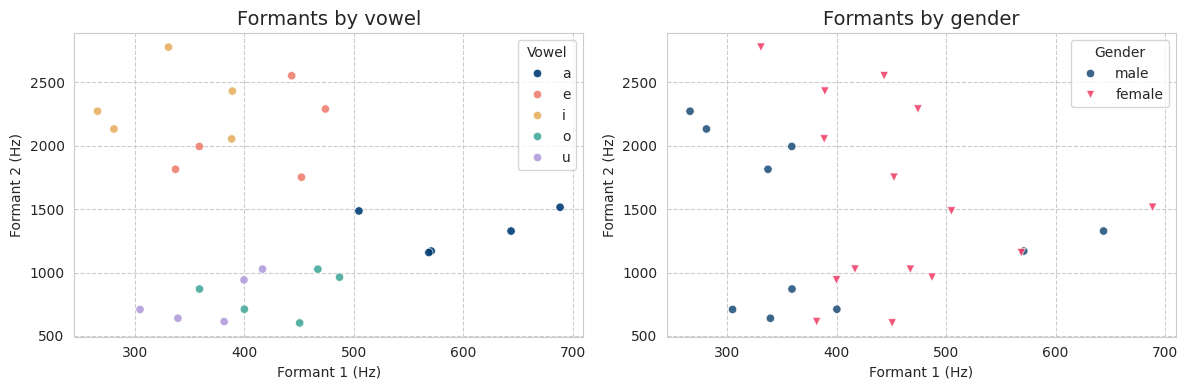

In [9]:
# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# First plot: Visualization by vowels
sns.scatterplot(
    data=data,
    x='formant_1',
    y='formant_2',
    hue='vowel',  # Distinguish by colors
    palette={'a': '#003D73', 'e': '#EF8070', 'i': '#E6B062', 'o': '#46A99B', 'u': '#B39DDB'},
    alpha=0.9,  # Transparency of the points
    ax=axes[0]  # Assign to the first axis (ax)
)

# Adjustments for the first plot
axes[0].set_xlabel('Formant 1 (Hz)')
axes[0].set_ylabel('Formant 2 (Hz)')
axes[0].set_title('Formants by vowel', fontsize=14)
axes[0].grid(True, linestyle='--')
axes[0].legend(title='Vowel')  # Title for the legend

# Second plot: Visualization by gender
sns.scatterplot(
    data=data,
    x='formant_1',
    y='formant_2',
    hue='gender',  # Distinguish by colors
    style='gender',  # Distinguish by shapes
    palette={'male': '#27547D', 'female': '#EF436B'},  # Blue for males and pink for females
    markers={'male': 'o', 'female': 'v'},  # Circular shape for males and triangular for females
    alpha=0.9,  # Transparency of the points
    ax=axes[1]  # Assign to the second axis (ax)
)

# Adjustments for the second plot
axes[1].set_xlabel('Formant 1 (Hz)')
axes[1].set_ylabel('Formant 2 (Hz)')
axes[1].set_title('Formants by gender', fontsize=14)
axes[1].grid(True, linestyle='--')
axes[1].legend(title='Gender')  # Title for the legend

# Adjust space between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Preprocessing  

In this section, we begin to consider the **preprocessing** of different concepts, such as the **speaker's gender**, the **categorization of vowels**, and **standardization**.  

**Note:** The **limited number of records** in the dataset is taken into account, and therefore, there is a **potential margin of error** in the generalization of the information.

### Categorization

First, we will consider the **numerical categorization** of the `gender` variable for its subsequent implementation in the **linear regression model**.

In [10]:
data['gender'] = [1 if gender=='male' else 0 for gender in data['gender']]
data.head(4)

,speaker,vowel,gender,formant_1,formant_2
0,speaker1,a,1,570.786498,1169.612221
1,speaker1,e,1,337.030868,1815.008328
2,speaker1,i,1,265.779787,2273.368182
3,speaker1,o,1,358.982693,869.869944


### Standardization  

We consider two different methods for **standardizing** the data, both of which involve only the **formant features**.

**Note:** I will create a copy of the original dataset and apply the first method to it.

In [11]:
data_standarized = data.copy()

#### First Method: Standardization  

This method involves **standardizing the entire dataset** as a whole before applying any further processing or model implementation. In this approach, formants features, are scaled together based on the overall mean and variance of the dataset. This method assumes that the statistical properties of the data across all rows and features should be treated equally, which can be useful when we need a **global standardization** for all variables.

In [12]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the 'formant_1' and 'formant_2' columns using the scaler
data_standarized[['formant_1', 'formant_2']] = scaler.fit_transform(
    data_standarized[['formant_1', 'formant_2']]
)

#### Second Method: Standardization  

This method involves separating each row by vowel into distinct **subgroups**, and then standardizing each **subgroup** individually. By doing this, we ensure that the standardization process is applied specifically within each vowel category, rather than across all vowels together. This approach could help preserve the unique characteristics of each vowel while still achieving the desired scaling of the data. The standardization of each subgroup ensures that the statistical properties, such as mean and variance, are calculated separately for each vowel, potentially improving the performance of models that rely on vowel-specific patterns.

First step: Separate the data into subgroups by vowel.

In [13]:
# Filter data for vowel 'a'
vowel_a_data_s = data[data['vowel'] == 'a']

# Filter data for vowel 'e'
vowel_e_data_s = data[data['vowel'] == 'e']

# Filter data for vowel 'i'
vowel_i_data_s = data[data['vowel'] == 'i']

# Filter data for vowel 'u'
vowel_u_data_s = data[data['vowel'] == 'u']

Second step: Create a standard scaler instance for each vowel.

In [14]:
# Create the StandardScaler instance for each vowel
vowel_a_scaler = StandardScaler()
vowel_e_scaler = StandardScaler()
vowel_i_scaler = StandardScaler()
vowel_u_scaler = StandardScaler()

Third step: Apply the standard scaler to each vowel.

In [15]:
# Apply the scaler to each vowel dataset using .loc to avoid the warning
vowel_a_data_s.loc[:, ['formant_1', 'formant_2']] = vowel_a_scaler.fit_transform(
    vowel_a_data_s[['formant_1', 'formant_2']]
)

vowel_e_data_s.loc[:, ['formant_1', 'formant_2']] = vowel_e_scaler.fit_transform(
    vowel_e_data_s[['formant_1', 'formant_2']]
)

vowel_i_data_s.loc[:, ['formant_1', 'formant_2']] = vowel_i_scaler.fit_transform(
    vowel_i_data_s[['formant_1', 'formant_2']]
)

vowel_u_data_s.loc[:, ['formant_1', 'formant_2']] = vowel_u_scaler.fit_transform(
    vowel_u_data_s[['formant_1', 'formant_2']]
)

## Models  

I will apply two different models: **Support Vector Machine** and **Logistic Regression**. I will focus on modeling the entire dataset after preprocessing, treating all vowels collectively within a single model.  

Once the models are trained, I will compute the **hyperplane separator** for males and females and compare the separators produced by both models. The goal is to evaluate how well each model distinguishes between genders based on the **formant_1** and **formant_2** features.  

Both models will use the same formula to ensure consistency in how the `gender` feature is modeled, allowing for a fair comparison between the performance of the **SVM** and **Logistic Regression** approaches.

In [16]:
# Formula used for statmodels
formula = 'gender ~ formant_1 + formant_2'

### Generalized Model  

I created the **Logistic Regression** and **SVM** models using the formula defined previously.

In [28]:
# Fit a logistic regression model (logit) using statsmodels
logit_model = smf.logit(
    formula=formula,       # Specifies target and features
    data=data_standarized  # Data for the model
).fit()

# Initialize and fit the SVM model with a linear kernel
svm_model = SVC(kernel='linear')  # SVM with linear decision boundary
svm_model.fit(
    data_standarized[['formant_1', 'formant_2']],
    data_standarized['gender'].to_numpy()  # Flatten target to 1D
)

Optimization terminated successfully.
         Current function value: 0.592756
         Iterations 6


SVC(kernel='linear')

We now proceed to analyze the **boundary hyperplane** that separates male and female voices for each model. By visualizing this boundary, we can better understand how the **Logistic Regression** and **SVM** models classify the data. This comparison allows us to evaluate the differences in the decision boundaries generated by the two models and to determine how well each model captures the patterns in the data related to gender classification based on the **formant_1** and **formant_2** features.

In [29]:
x_min = data_standarized['formant_1'].min()
x_max = data_standarized['formant_1'].max()

# Create range for formant_1 (X1)
X1 = np.linspace(x_min, x_max, 100)

# Logistic Regression decision boundary
logit_params = logit_model.params
X2_logit = -(logit_params.iloc[0] + logit_params.iloc[1] * X1) / logit_params.iloc[2]  # Boundary for formant_2

# SVM decision boundary
svm_coef = svm_model.coef_[0]
svm_intercept = svm_model.intercept_[0]
X2_svm = -(svm_coef[0] * X1 + svm_intercept) / svm_coef[1]  # Boundary for formant_2

I can observe that the **SVM model** performs slightly better than the **Logistic Regression model**. Both models successfully separate male and female voices. However, it is worth noting that there are two male voice clips located within the region predominantly occupied by female voices.  

While both models demonstrate good performance, the **SVM model** shows a slight advantage by more effectively separating these two clips of different genders compared to the **Logistic Regression model**. This suggests that the **SVM model** is better at capturing the subtle distinctions in the data for this classification task.

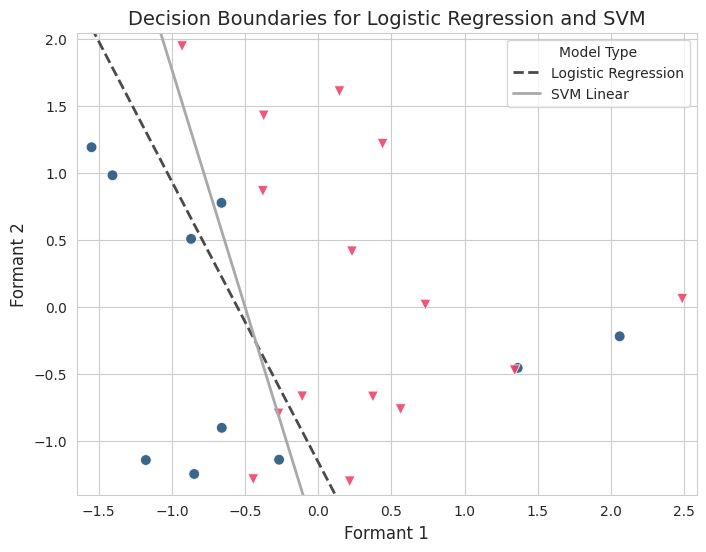

In [30]:
# Plot the scatter plot without the gender legend
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.scatterplot(
    data=data_standarized,
    x='formant_1',
    y='formant_2',
    hue='gender',
    style='gender',
    palette={1: '#27547D', 0: '#EF436B'},
    markers={1: 'o', 0: 'v'},
    alpha=0.9,
    s=60,  # Adjust the marker size for better visibility
    legend=None  # Remove the gender legend
)

# Plot the logistic regression decision boundary
sns.lineplot(x=X1, y=X2_logit, color='#4A4A4A', label='Logistic Regression', linewidth=2, linestyle='--')

# Plot the SVM decision boundary
sns.lineplot(x=X1, y=X2_svm, color='#A9A9A9', label='SVM Linear', linewidth=2, linestyle='-')

# Add labels and title
plt.xlabel('Formant 1', fontsize=12)
plt.ylabel('Formant 2', fontsize=12)
plt.title('Decision Boundaries for Logistic Regression and SVM', fontsize=14)

# Create the legend only for the model types
plt.legend(title='Model Type', loc='upper right', fontsize=10)

# Adjust the limits to make sure both decision boundaries are visible
plt.xlim(data_standarized['formant_1'].min() - 0.1, data_standarized['formant_1'].max() + 0.1)
plt.ylim(data_standarized['formant_2'].min() - 0.1, data_standarized['formant_2'].max() + 0.1)

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In addition, considering the **Precision** and **Recall** metrics, I observed that the **SVM model** performs better. While maintaining the same **Recall** as the **Logistic Regression model**, the **SVM model** increases **Precision**. This improvement indicates that the SVM model has a greater capacity to make accurate predictions and more effectively separates the two classes.

In [39]:
# Compute predictions for both models
logit_preds = (logit_model.predict(data_standarized[['formant_1', 'formant_2']]) > 0.5).astype(int)
svm_preds = svm_model.predict(data_standarized[['formant_1', 'formant_2']])

# Compute Precision and Recall for both models
precision_logit = precision_score(data_standarized['gender'], logit_preds)
recall_logit = recall_score(data_standarized['gender'], logit_preds)

precision_svm = precision_score(data_standarized['gender'], svm_preds)
recall_svm = recall_score(data_standarized['gender'], svm_preds)

# Store Precision and Recall in a pandas DataFrame
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Precision': [precision_logit, precision_svm],
    'Recall': [recall_logit, recall_svm]
})

# Apply a background color to the Precision cell for SVM
def highlight_svm_precision(row):
    if row['Model'] == 'SVM':
        return ['background-color: #00C851' if col == 'Precision' else '' for col in metrics_df.columns]
    else:
        return ['' for col in metrics_df.columns]

metrics_df = metrics_df.style.apply(highlight_svm_precision, axis=1)

metrics_df

,Model,Precision,Recall
0,Logistic Regression,0.777778,0.700000
1,SVM,0.875000,0.700000


Analyzing the **F-Beta Score** metric, which balances the **F1-Score**, I observed that the models perform worse when giving greater weight to the **Recall** metric with higher beta parameters. This metric is crucial as it helps identify a model's overall ability to distinguish between genders effectively. A higher performance in this capacity could lead to generating a parameter that defines the stronger or sharper fundamental harmonic of a pitch in a voice.

**Note:** The [Emastered blog](https://emastered.com/es/blog/formant-shifting) explains how gender influences the strength or sharpness of a pitch's fundamental harmonic and its associated formants.

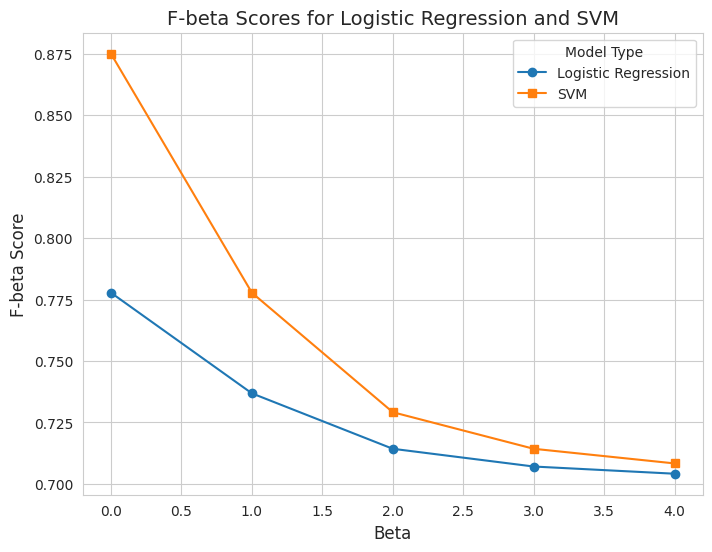

In [32]:
# Compute F-beta scores for beta values from 0 to 4
betas = range(0, 5)
logit_fbeta_scores = [fbeta_score(data_standarized['gender'], logit_preds, beta=beta) for beta in betas]
svm_fbeta_scores = [fbeta_score(data_standarized['gender'], svm_preds, beta=beta) for beta in betas]

# Plot F-beta scores
plt.figure(figsize=(8, 6))
plt.plot(betas, logit_fbeta_scores, marker='o', label='Logistic Regression')
plt.plot(betas, svm_fbeta_scores, marker='s', label='SVM')
plt.xlabel('Beta', fontsize=12)
plt.ylabel('F-beta Score', fontsize=12)
plt.title('F-beta Scores for Logistic Regression and SVM', fontsize=14)
plt.legend(title='Model Type', loc='upper right', fontsize=10)
plt.grid(True)
plt.show()